# Reorganize and preprocess the data from the BBBC_039 dataset
This notebook splits the data into the train, validation and test partitions according to the metadata from the dataset. Images are converted from TIF format to PNG and masks are preprocessed to contain labels for each nuclei as well as contours.

In [1]:
import os
import shutil
import random
import numpy as np
import skimage.segmentation
import skimage.io
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from tqdm import tqdm
from utils import get_loaders
from UNET.dataset import BBBC_039_data

In [2]:
# create config dictionary
config = {
    'source_dir': '../dataset/BBBC_039',
    'dest_dir': '../dataset/BBBC_039_formatted',
    'min_nucleus_size': 25,
    'boundary_size': 2,
}

In [ ]:
os.makedirs(config['dest_dir'], exist_ok=True)

In [3]:
def read_file_lines(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return lines

train_files = read_file_lines(os.path.join(config['source_dir'], 'metadata', 'training.txt'))
test_files = read_file_lines(os.path.join(config['source_dir'], 'metadata', 'test.txt'))
val_files = read_file_lines(os.path.join(config['source_dir'], 'metadata', 'validation.txt'))

In [4]:
train_files

['IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.png\n',
 'IXMtest_A15_s5_w1825174D4-ED30-490C-9635-6196417D6C9D.png\n',
 'IXMtest_A16_s3_w1032BE329-E21B-4E1B-B4B8-58700685EE0C.png\n',
 'IXMtest_A18_s1_w1BFDF1C94-9C1F-4F5F-BBC1-05196333B1BF.png\n',
 'IXMtest_A20_s4_w153DE191F-B112-471B-AC0A-FAD27990714B.png\n',
 'IXMtest_A21_s1_w1D8BF2790-C628-4109-94AF-DF6D8A3480B6.png\n',
 'IXMtest_A24_s9_w152CD6793-DA45-4975-869A-CBD49D645E37.png\n',
 'IXMtest_B12_s9_w1ABE4C6B8-6110-4D7D-B782-94C43FDC2E1F.png\n',
 'IXMtest_B20_s2_w159B9FE71-035A-4DED-B0CA-C76916C968BC.png\n',
 'IXMtest_B21_s3_w141E785B1-44FE-4ED0-9CCE-6FF076EFE9FE.png\n',
 'IXMtest_B21_s4_w1521471E0-9BD7-492A-8739-9C782C2585B0.png\n',
 'IXMtest_B21_s7_w1276972A2-1794-4A98-8E76-876A597C346B.png\n',
 'IXMtest_B22_s6_w19397283D-2426-4942-8A0F-EB75E1D48C2D.png\n',
 'IXMtest_B22_s8_w10754C18F-B059-47B4-A423-FF429B984D80.png\n',
 'IXMtest_B23_s1_w152C21D3B-75A9-4FF9-839A-23E6CE19AEEC.png\n',
 'IXMtest_C02_s4_w1661FF37C-AB9B-4038-BD

In [5]:
'''
Create 3 folders: train, val and test; each folder contains 2 sub directories: images and masks.
Convert to PNG, a normalization function. Values between [0, 1], extension converted to '.png'.
'''

def convert_to_png(raw_img_path):
    raw_img = skimage.io.imread(raw_img_path)
    percentile = 99.9
    high = np.percentile(raw_img, percentile)
    low = np.percentile(raw_img, 100-percentile)
    
    img = np.minimum(high, raw_img)
    img = np.maximum(low, img)
    img = (img - low) / (high - low)
    img = skimage.util.img_as_ubyte(img)
    return img


def organize_files(file_list, dir_name):
    target_dir = os.path.join(config['dest_dir'], dir_name)
    os.makedirs(target_dir, exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'masks'), exist_ok=True)
    
    for file in file_list:
        file = file.strip()
        file_name = file.strip('.png\n')
        img_src = os.path.join(config['source_dir'], 'images', file_name + '.tif')
        img = convert_to_png(img_src)
        img_dest = os.path.join(target_dir, 'images', file_name + '.png')
        skimage.io.imsave(img_dest, img)
        
        mask_src = os.path.join(config['source_dir'], 'masks', file_name + '.png')
        mask_dest = os.path.join(target_dir, 'masks', file_name + '.png')
        shutil.copy(mask_src, mask_dest)

In [13]:
organize_files(train_files, 'train')
organize_files(test_files, 'test')
organize_files(val_files, 'val')
print('Done')

Done


IXMtest_A15_s5_w1825174D4-ED30-490C-9635-6196417D6C9D.png


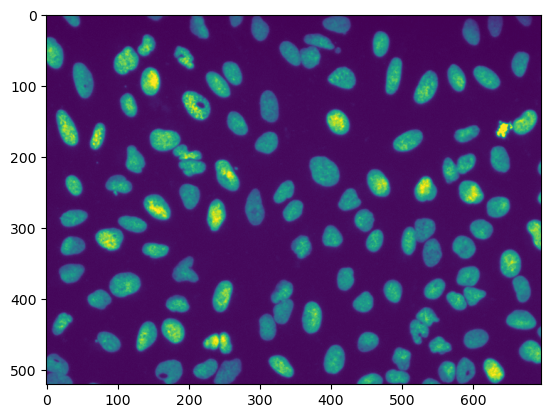

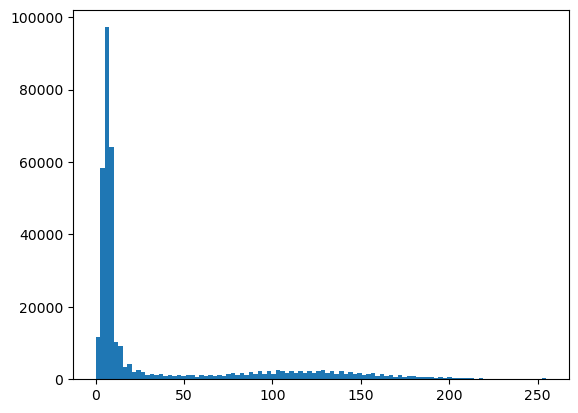

In [6]:
# print sample image
# rand_file_name = train_files[random.randint(0, len(train_files) - 1)].strip('\n')
rand_file_name = train_files[1].strip('\n')
print(rand_file_name)
img = skimage.io.imread(os.path.join(config['dest_dir'], 'train/images', rand_file_name))
plt.imshow(img)
plt.show()
plt.hist(img.flatten(), bins=100)
plt.show()

In [7]:
img.shape

(520, 696)

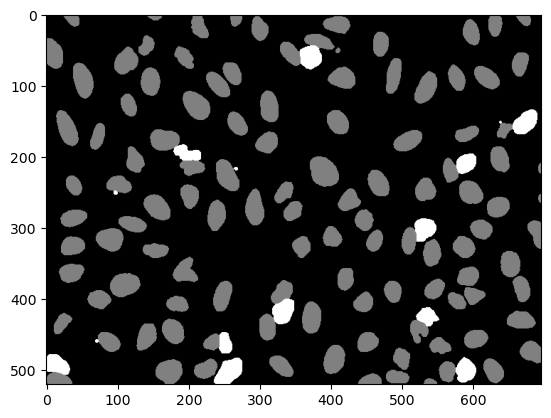

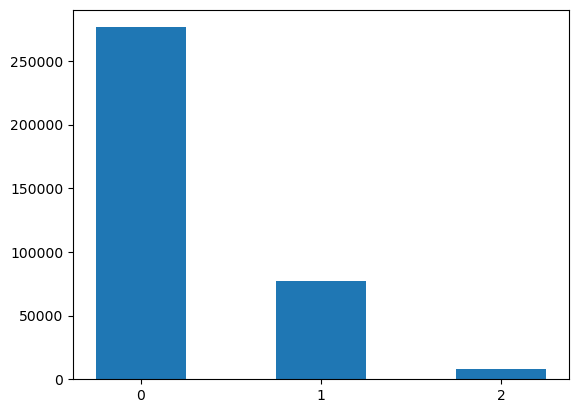

In [8]:
rand_file_name = train_files[1].strip('\n')
rand_mask = skimage.io.imread(os.path.join(config['dest_dir'], 'train/masks', rand_file_name))
if len(rand_mask.shape) == 3:
    rand_mask = rand_mask[:, :, 0]
plt.imshow(rand_mask, cmap='gray')
plt.show()
rand_mask_min = np.amin(rand_mask)
rand_mask_max = np.amax(rand_mask)
bin_edges = np.arange(rand_mask_min-0.5, rand_mask_max+1.5, 1)
plt.hist(rand_mask.flatten(), bins=bin_edges, rwidth=0.5)
plt.xticks(np.arange(rand_mask_min, rand_mask_max+1, 1))
plt.show()

(520, 696, 3)


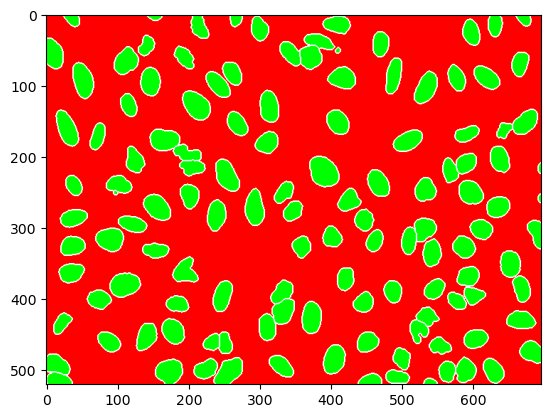

In [39]:
rand_file_name = train_files[1].strip('\n')
rand_mask = skimage.io.imread(os.path.join(config['dest_dir'], 'train/masks', rand_file_name))
if len(rand_mask.shape) == 3:
    rand_mask = rand_mask[:, :, 0]
    
# label the annotations
rand_mask = skimage.morphology.label(rand_mask)

# filter small objects
rand_mask = skimage.morphology.remove_small_objects(rand_mask, min_size=config['min_nucleus_size'])

# find boundaries
boundaries = skimage.segmentation.find_boundaries(rand_mask)

# thicken boundaries (dilatation)
for k in range(2, config["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)

# label_binary has 3 layers over the 2D image:
#   * label_binary[:, :, 0] -> the background is 1 and the nuclei are 0
#   * label_binary[:, :, 1] -> the nuclei without the contour is 1 (a form of eroded nuclei is 1)
#   * label_binary[:, :, 2] -> the contour is 1 (the contour has a thickness specified in config)
label_binary = np.zeros((rand_mask.shape + (3,)))
label_binary[(rand_mask == 0) & (boundaries == 0), 0] = 1
label_binary[(rand_mask != 0) & (boundaries == 0), 1] = 1
label_binary[(boundaries == 1)] = 1
print(label_binary.shape)
plt.imshow(label_binary)
plt.show()
# print(np.amax(rand_mask))
# plt.imshow(rand_mask, cmap='nipy_spectral')
# plt.show()
# plt.imshow(boundaries)
# plt.show()

In [51]:
def create_output_targets(file_list, dir_name):
    os.makedirs(os.path.join(config['dest_dir'], dir_name, 'boundary_labels'), exist_ok=True)
    for file_name in tqdm(file_list):
        file_name = file_name.strip()
        file_name = file_name.strip('\n')
        
        annot = skimage.io.imread(os.path.join(config['dest_dir'], dir_name, 'masks', file_name))
        
        if len(annot.shape) == 3:
            annot = annot[:,:,0]
        
        # label the annotations
        annot = skimage.morphology.label(annot)
        
        # filter small objects
        annot = skimage.morphology.remove_small_objects(annot, min_size=config['min_nucleus_size'])
        
        # find boundaries
        boundaries = skimage.segmentation.find_boundaries(annot)
        
        # "thicken" boundaries (dilatation)
        for k in range(2, config["boundary_size"], 2):
            boundaries = skimage.morphology.binary_dilation(boundaries)
                
        # label_binary has 3 layers over the 2D image:
        #   * label_binary[:, :, 0] -> the background is 1 and the nuclei are 0
        #   * label_binary[:, :, 1] -> the nuclei without the contour is 1 (a form of eroded nuclei is 1)
        #   * label_binary[:, :, 2] -> the contour is 1 (the contour has a thickness specified in config)
        label_binary = np.zeros((annot.shape + (3,)))
        label_binary[(annot == 0) & (boundaries == 0), 0] = 1
        label_binary[(annot != 0) & (boundaries == 0), 1] = 1
        label_binary[(boundaries == 1)] = 1
        
        # Create an empty array with the same shape as label_binary but with integer data type as uint8
        output_image = np.zeros_like(label_binary, dtype=np.uint8)
        
        # Convert the binary values (0s and 1s) to suitable intensity values (0 and 255)
        output_image[label_binary == 1] = 255

        label_dest = os.path.join(config['dest_dir'], dir_name, 'boundary_labels', file_name)
        skimage.io.imsave(label_dest, output_image)

In [52]:
create_output_targets(train_files, 'train')
create_output_targets(test_files, 'test')
create_output_targets(val_files, 'val')

 33%|███▎      | 33/100 [00:01<00:02, 27.42it/s]/var/folders/wn/w5pym_515wv_7dn9q4k4y2qm0000gn/T/ipykernel_82413/2168880361.py:41: UserWarning: ../dataset/BBBC_039_formatted/train/boundary_labels/IXMtest_F13_s7_w13C1B1D8C-293E-454F-B0FD-6C2C3F9F5173.png is a low contrast image
  skimage.io.imsave(label_dest, output_image)
 69%|██████▉   | 69/100 [00:02<00:01, 27.68it/s]/var/folders/wn/w5pym_515wv_7dn9q4k4y2qm0000gn/T/ipykernel_82413/2168880361.py:41: UserWarning: ../dataset/BBBC_039_formatted/train/boundary_labels/IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174.png is a low contrast image
  skimage.io.imsave(label_dest, output_image)
 72%|███████▏  | 36/50 [00:01<00:00, 27.62it/s]/var/folders/wn/w5pym_515wv_7dn9q4k4y2qm0000gn/T/ipykernel_82413/2168880361.py:41: UserWarning: ../dataset/BBBC_039_formatted/val/boundary_labels/IXMtest_L10_s6_w12D12D64C-2639-4CA8-9BB4-99F92C9B7068.png is a low contrast image
  skimage.io.imsave(label_dest, output_image)
100%|██████████| 50/50 [00:01<0

In [55]:
# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 1
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 520 originally
IMAGE_WIDTH = 240   # 696 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = '../dataset/BBBC_039_formatted/train/images'
TRAIN_MASK_DIR = '../dataset/BBBC_039_formatted/train/boundary_labels'
VAL_IMG_DIR = '../dataset/BBBC_039_formatted/val/images'
VAL_MASK_DIR = '../dataset/BBBC_039_formatted/val/boundary_labels'
TRANSFORM_TO_PNG = False

train_transform = A.Compose(
    [
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2()
    ]
)

train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY
    )

Batch: 2
Data shape: torch.Size([16, 1, 160, 240])
Targets shape: torch.Size([16, 160, 240])


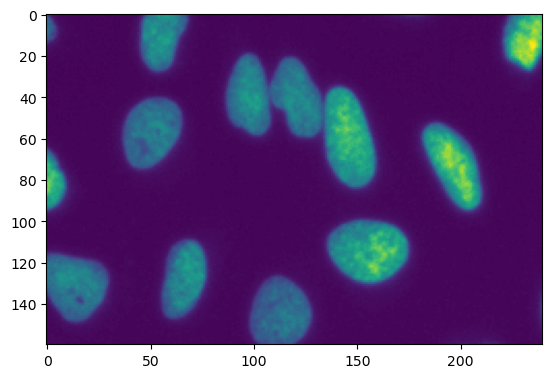

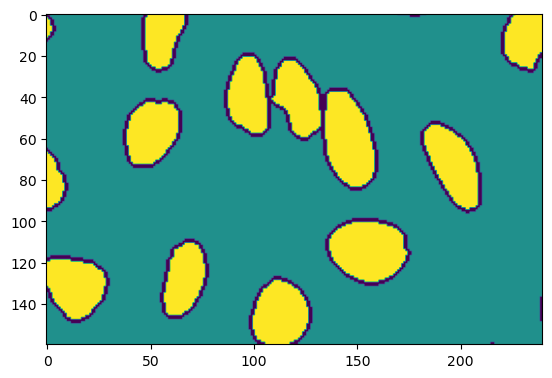

In [73]:
for batch_idx, (data, targets) in enumerate(train_loader):
    if batch_idx < 2:
        continue
    print(f'Batch: {batch_idx}')
    print(f'Data shape: {data.shape}')
    print(f'Targets shape: {targets.shape}')
    plt.imshow(data[10,0,:,:])
    plt.show()
    plt.imshow(targets[10,:,:])
    plt.show()
    break
    
train_ds = BBBC_039_data(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

(520, 696, 3)


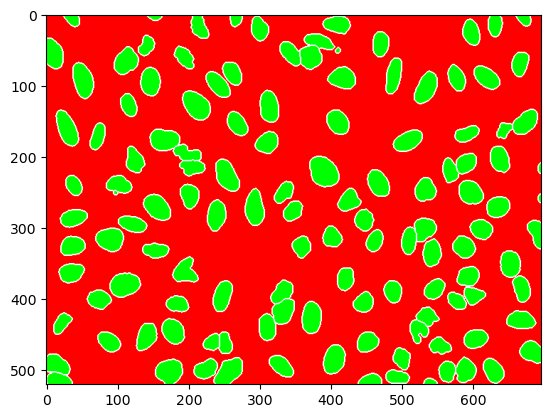

In [76]:
rand_file_name = train_files[1].strip('\n')
img = skimage.io.imread(os.path.join(config['dest_dir'], 'train/boundary_labels', rand_file_name))
print(img.shape)
plt.imshow(img)
plt.show()